In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='', project_access_token='')
pc = project.project_context


<div style="text-align: center;">
<h1>IBM Advance Data Science Capstone Project</h1>
    <h3>Credit Card Fraud Detection</h3>
</div>
<br />
<hr />

<h3>Import lLibraries</h3>

In [30]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import logging
tf.logging.set_verbosity(tf.logging.ERROR) #For ignore error 
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


In [3]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

LABELS = ["Normal", "Fraud"]
RANDOM_SEED = 50

<h3>Loading Data</h3>

In [4]:
!pip install ibm-cos-sdk

In [5]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_bcd0f635b5bb4623a5b44f109e54c3b8 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = <>.get_object(Bucket='capstoneproject-donotdelete-pr-ifvtx7zkb64msz',Key='creditcard.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df_data_1.shape

(284807, 31)

In [7]:
df_data_1.isnull().values.any()

False

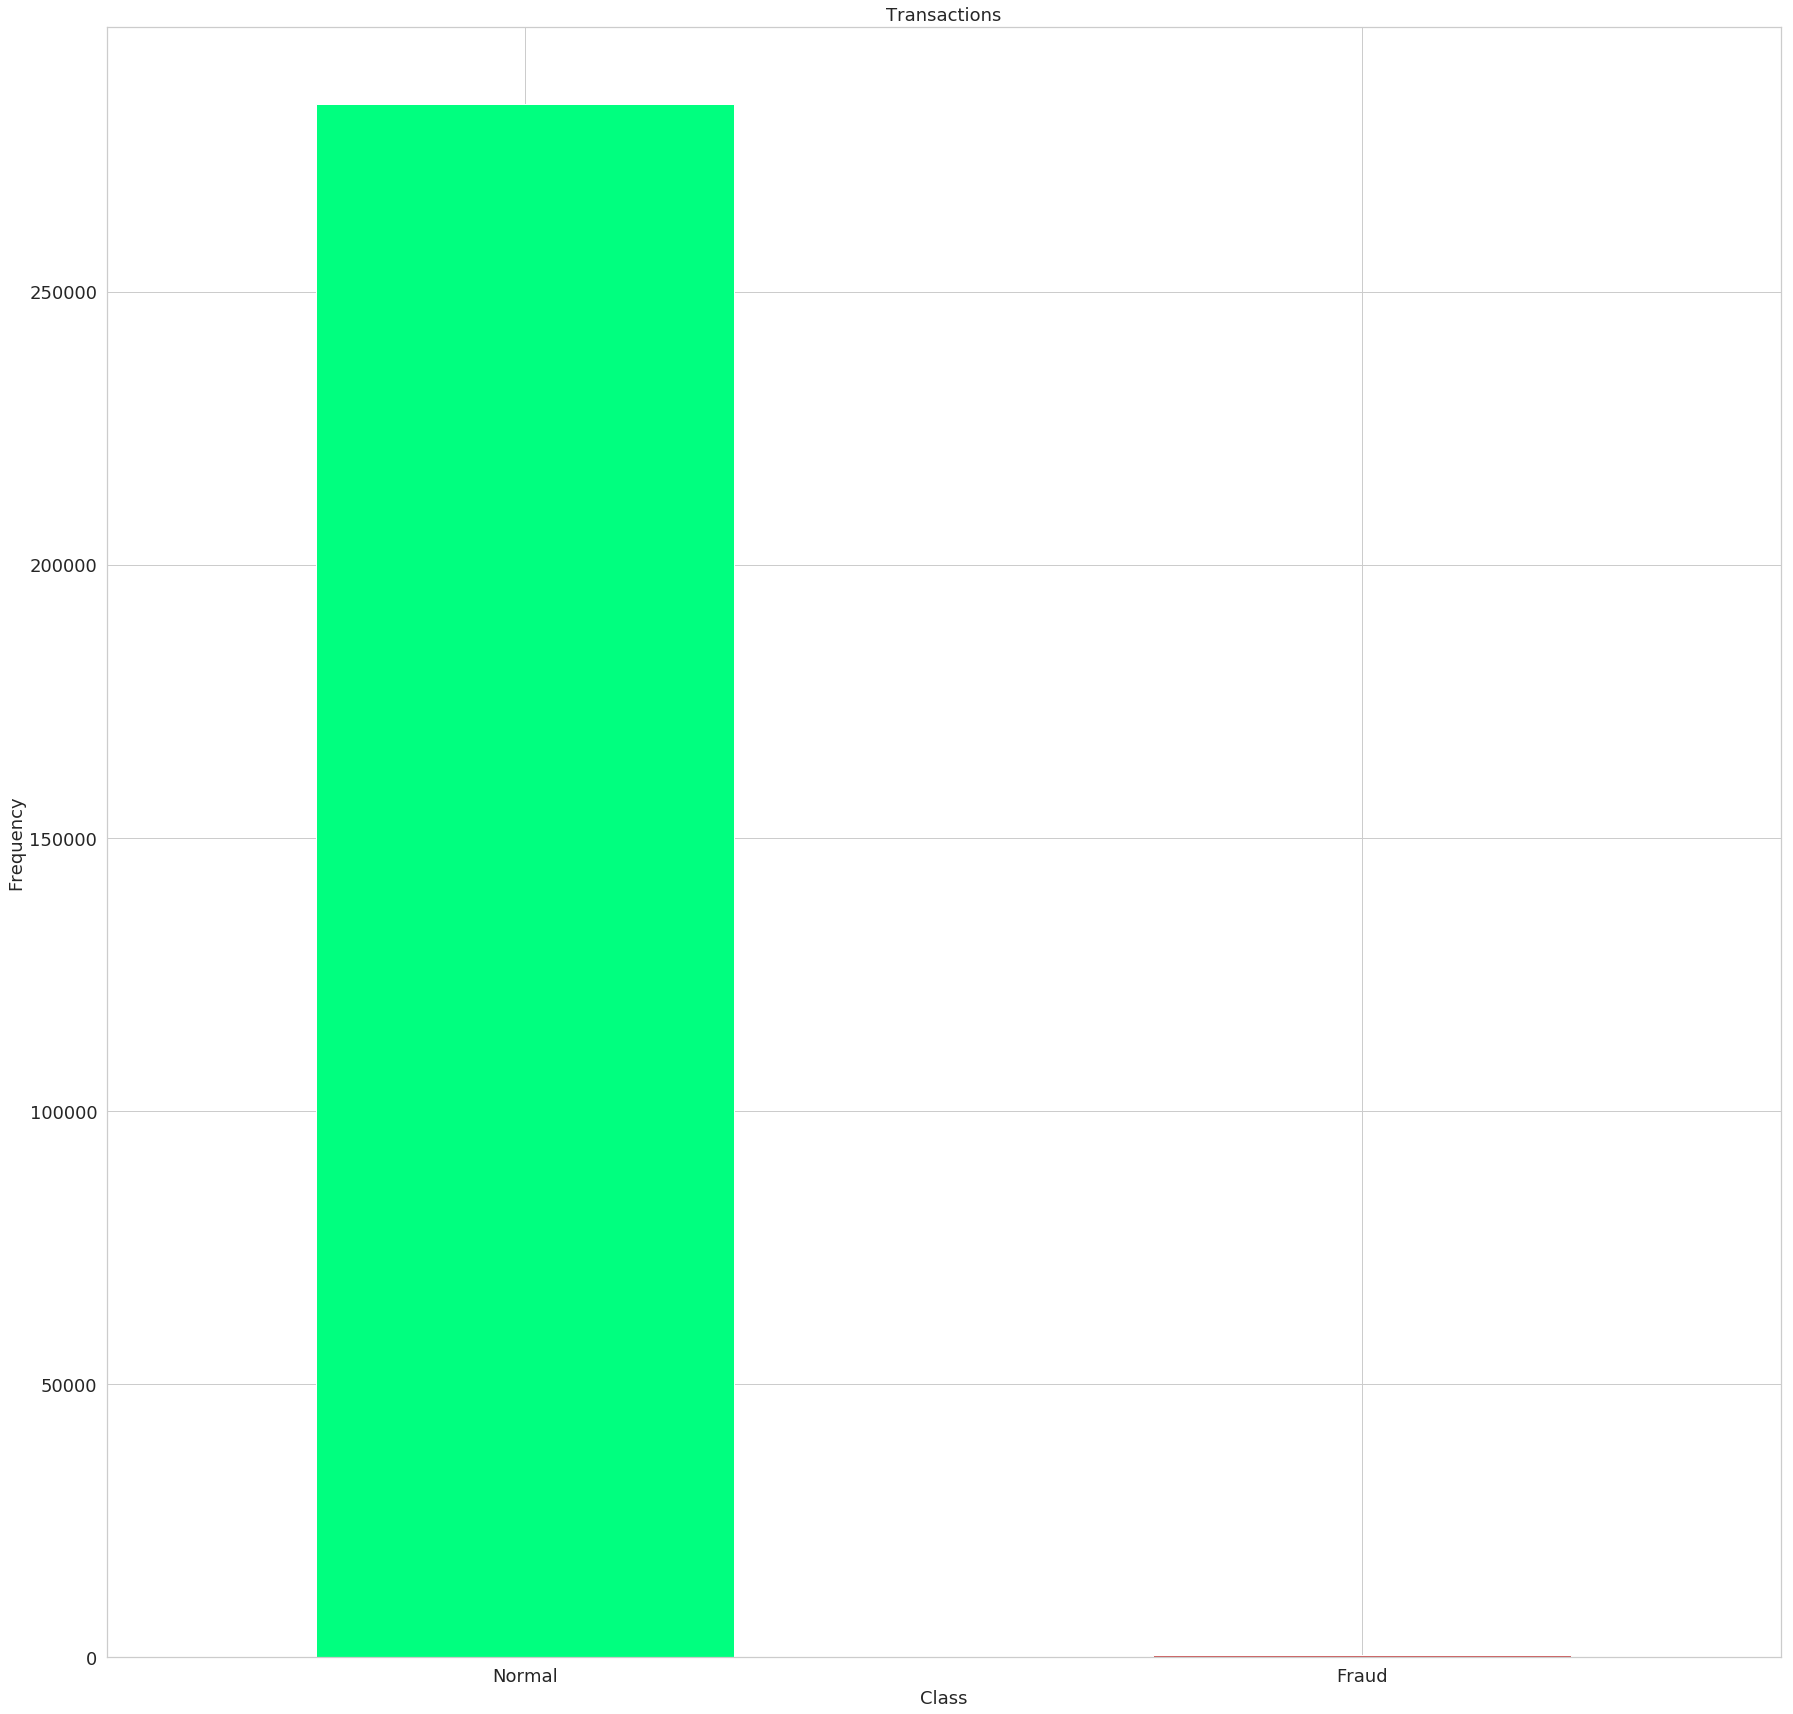

In [11]:
df_classes = pd.value_counts(df_data_1['Class'], sort = True)

ax = df_classes.plot.bar(color=["springgreen","IndianRed"], rot=0, title="Transactions",fontsize=18, figsize=(30,30))

ax.set_xlabel("Class")
ax.set_ylabel("Frequency")

plt.xticks(range(2), LABELS)
plt.show()

In [13]:
frauds = df_data_1[df_data_1.Class == 1]
normal = df_data_1[df_data_1.Class == 0]

print("Normal Transitions: {} \nFraud Transitions: {}".format(normal.shape, frauds.shape))

Normal Transitions: (284315, 31) 
Fraud Transitions: (492, 31)


In [15]:
print("Normal Transitions Amount Descripe: {} \n--\n\nFraud Transitions Amount Descripe: {}".format(normal.Amount.describe(), frauds.Amount.describe()))

Normal Transitions Amount Descripe: count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64 
--

Fraud Transitions Amount Descripe: count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


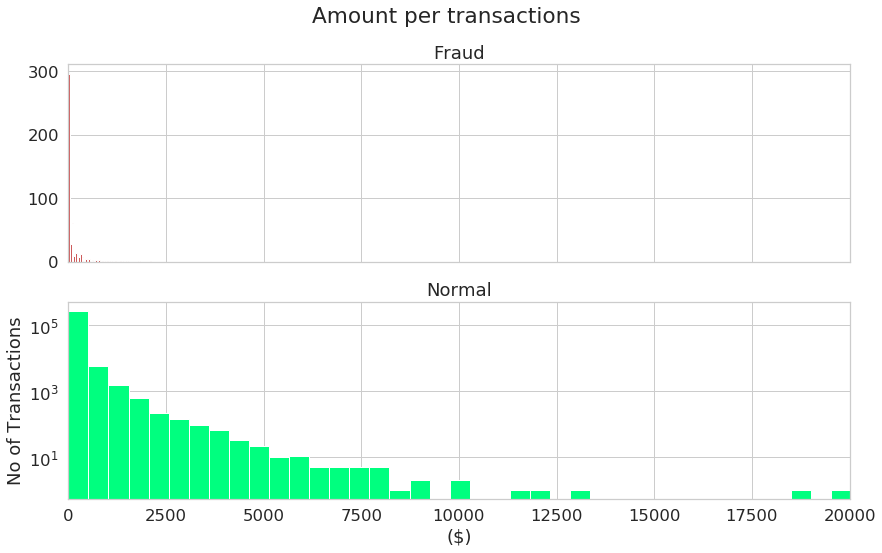

In [22]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transactions')

bins = 50

ax1.hist(frauds.Amount, color = 'IndianRed',bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, color = 'springgreen', bins = bins)
ax2.set_title('Normal')

plt.xlabel('($)')
plt.ylabel('No of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

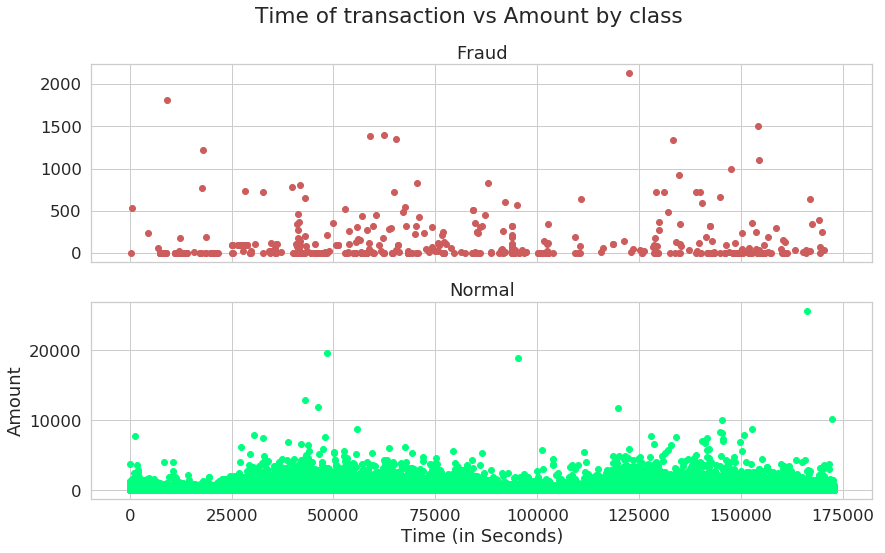

In [25]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount, color = 'IndianRed')
ax1.set_title('Fraud')

ax2.scatter(normal.Time,normal.Amount, color = 'springgreen')
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

## Data cleansing


In [28]:
from sklearn.preprocessing import StandardScaler

df_data = df_data_1.drop(['Time'], axis=1)
df_data['Amount'] = StandardScaler().fit_transform(df_data['Amount'].values.reshape(-1, 1))

x_train, x_test = train_test_split(df_data, test_size=0.3, random_state=RANDOM_SEED)

x_train = x_train[x_train.Class == 0]
x_train = x_train.drop(['Class'], axis=1)
y_test = x_test['Class']
x_test = x_test.drop(['Class'], axis=1)
x_train = x_train.values
x_test = x_test.values


print("x_train: {} \nx_test: {}".format(x_train.shape, x_test.shape))

x_train: (199008, 29) 
x_test: (85443, 29)


# Model
<p>Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons.</p>

In [31]:

input_dim = x_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)

decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [32]:
epoch = 50
batch_size = 40

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(x_train, x_train,
                    epochs=epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 199008 samples, validate on 85443 samples
Epoch 1/50
199008/199008 [==============================] - 171s 858us/step - loss: 0.8397 - acc: 0.5774 - val_loss: 0.7914 - val_acc: 0.6664
Epoch 2/50
199008/199008 [==============================] - 120s 603us/step - loss: 0.7603 - acc: 0.6693 - val_loss: 0.7759 - val_acc: 0.6726
Epoch 3/50
199008/199008 [==============================] - 124s 622us/step - loss: 0.7505 - acc: 0.6748 - val_loss: 0.7690 - val_acc: 0.6844
Epoch 4/50
199008/199008 [==============================] - 146s 734us/step - loss: 0.7443 - acc: 0.6791 - val_loss: 0.7641 - val_acc: 0.6792
Epoch 5/50
199008/199008 [==============================] - 141s 708us/step - loss: 0.7415 - acc: 0.6799 - val_loss: 0.7613 - val_acc: 0.6835
Epoch 6/50
199008/199008 [==============================] - 139s 698us/step - loss: 0.7392 - acc: 0.6810 - val_loss: 0.7615 - val_acc: 0.6816
Epoch 7/50
199008/199008 [==============================] - 145s 730us/step - loss: 0.7383 - acc:

In [34]:
autoencoder = load_model('model.h5')

## Model evaluation

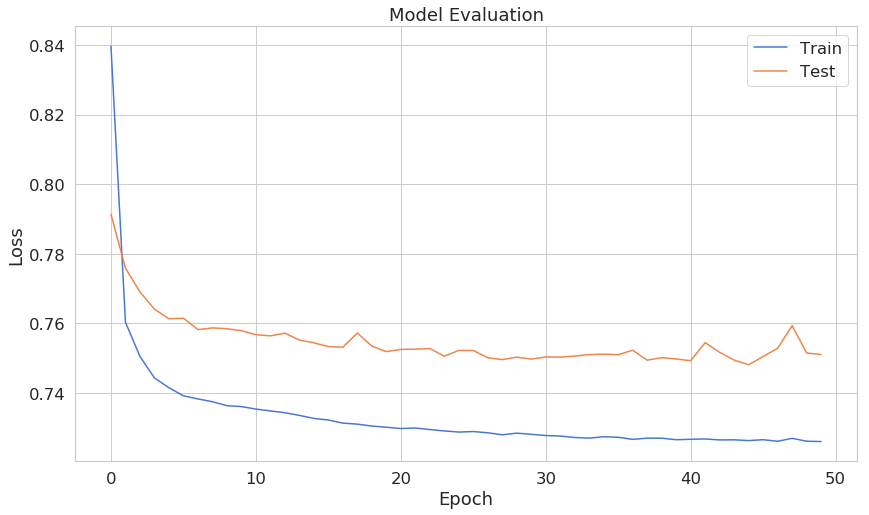

In [35]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Evaluation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right');

In [37]:
predictions = autoencoder.predict(x_test)

mse = np.mean(np.power(x_test - predictions, 2), axis=1)

df_err = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})

df_err.describe()

,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.740300,0.001592
std,3.349338,0.039865
min,0.045763,0.000000
25%,0.247906,0.000000
50%,0.387917,0.000000
75%,0.618083,0.000000
max,269.822409,1.000000


## Error without fraud

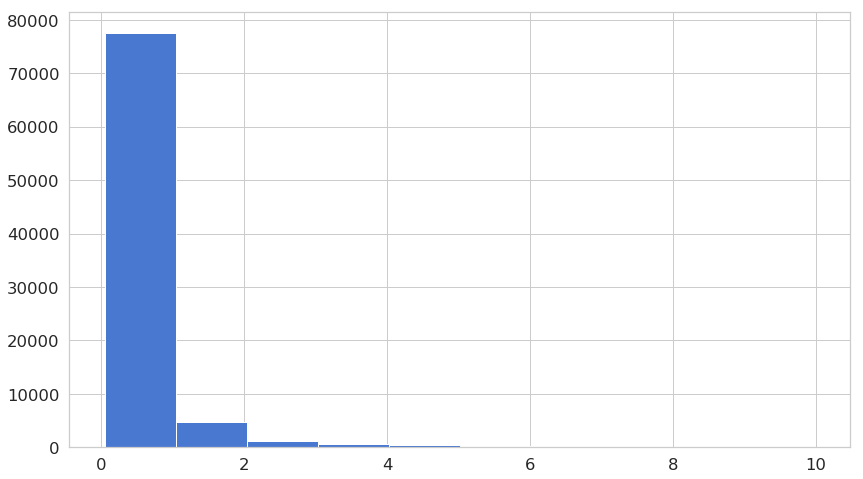

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
norm_err = df_err[(df_err['true_class']== 0) & (df_err['reconstruction_error'] < 10)]
_ = ax.hist(norm_err.reconstruction_error.values, bins=10)

## Error with fraud

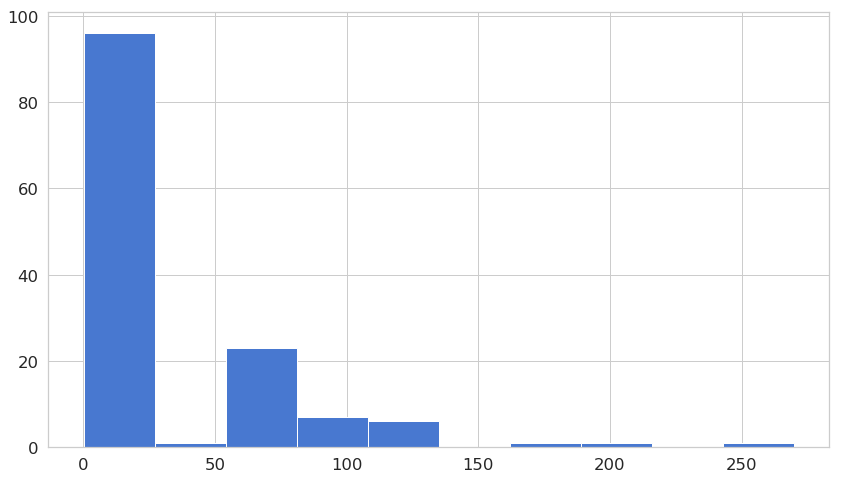

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_err = df_err[df_err['true_class'] == 1]
_ = ax.hist(fraud_err.reconstruction_error.values, bins=10)

## ROC curves

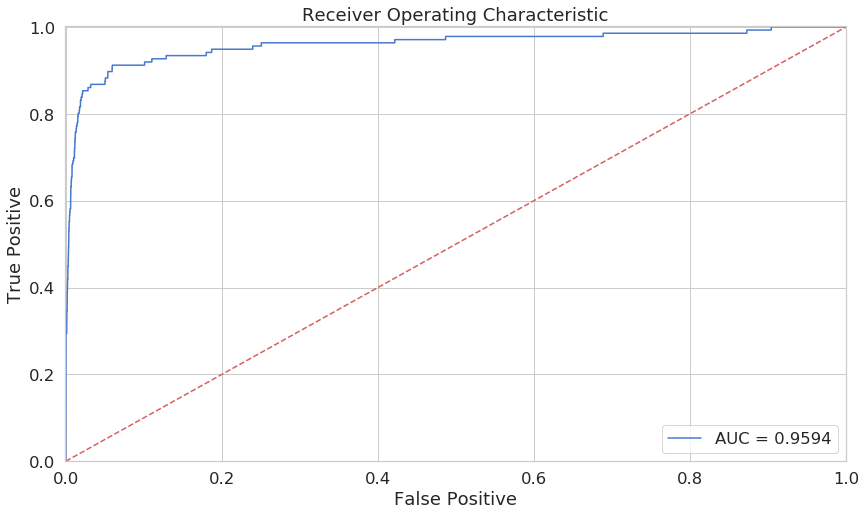

In [40]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(df_err.true_class, df_err.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.show();

## Precision / Recall

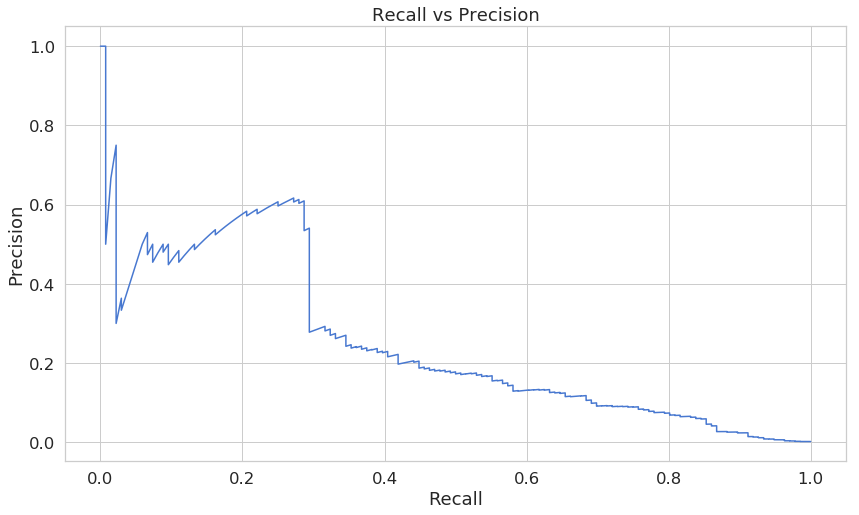

In [41]:
precision, recall, th = precision_recall_curve(df_err.true_class, df_err.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

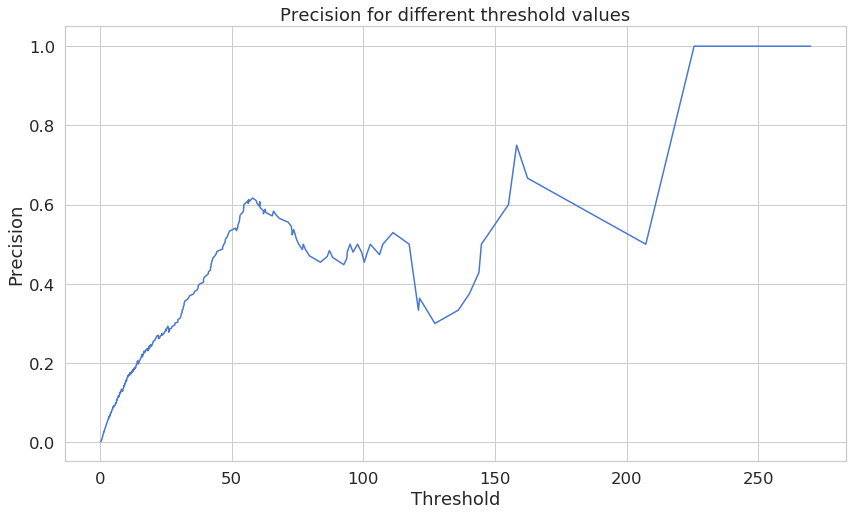

In [42]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

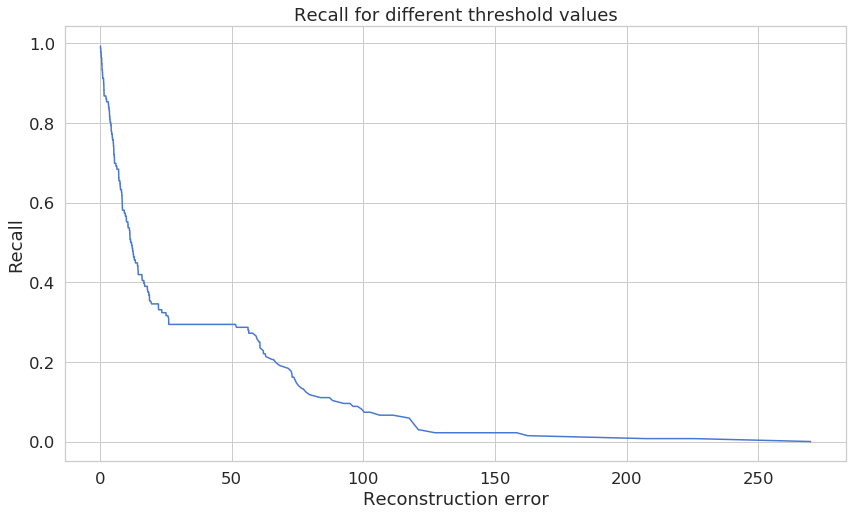

In [43]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

## Prediction

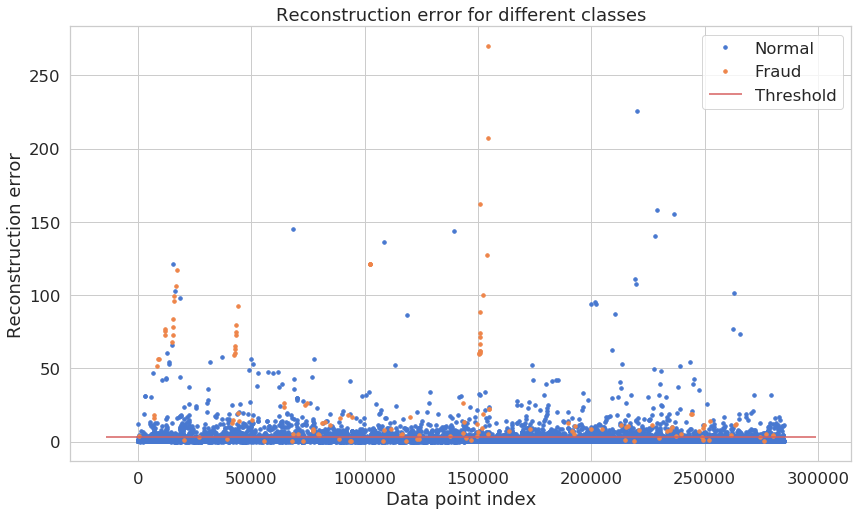

In [44]:
threshold = 2.9 # If the error is larger than a predefined threshold, mark it as a fraud

groups = df_err.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Confusion matrix

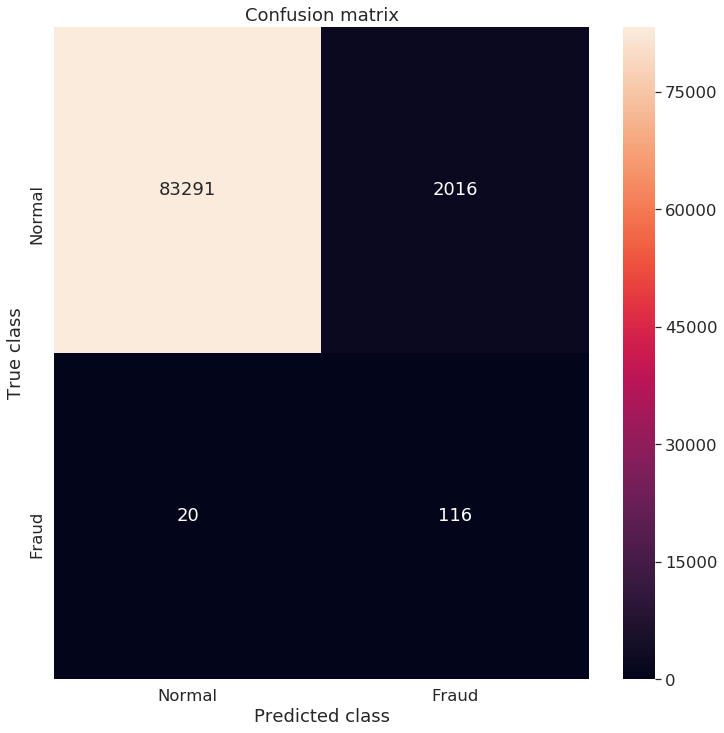

In [45]:
y_pred = [1 if e > threshold else 0 for e in df_err.reconstruction_error.values]
conf_matrix = confusion_matrix(df_err.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Deploy the model

In [57]:
ls -ltr 

total 64
drwxr-x--- 2 dsxuser dsxuser  4096 May 17 18:13 logs/
-rw-r----- 1 dsxuser dsxuser 43328 May 17 21:40 model.h5
-rw-r----- 1 dsxuser dsxuser 12656 May 17 22:16 mymodel.tgz


In [47]:
!tar -zcvf mymodel.tgz model.h5

model.h5


In [48]:
!pip install watson-machine-learning-client --upgrade

     |████████████████████████████████| 542kB 7.2MB/s eta 0:00:01
  Found existing installation: watson-machine-learning-client 1.0.376
    Uninstalling watson-machine-learning-client-1.0.376:
      Successfully uninstalled watson-machine-learning-client-1.0.376


In [49]:
# @hidden_cell

from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_credentials={
  "apikey": "",
  "iam_apikey_description": "Auto-generated for key ",
  "iam_apikey_name": "wdp-writer",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "",
  "instance_id": "",
  "url": "https://us-south.ml.cloud.ibm.com"
}

2020-05-17 22:19:00,451 - watson_machine_learning_client.metanames - WARNING - 'AUTHOR_EMAIL' meta prop is deprecated. It will be ignored.
2020-05-17 22:19:01,061 - watson_machine_learning_client.wml_client_error - WARNING - Failure during getting trained model details. (GET https://us-south.ml.cloud.ibm.com/v3/models/my_model.tgz)
Status code: 404, body: {
  "trace": "b4b8dc68b73120fe630846fb4031f345",
  "errors": [{
    "code": "cannot_find_job_status",
    "message": "Training job status cannot be obtained.",
    "more_info": "http://watson-ml-api.mybluemix.net/"
  }]
}
2020-05-17 22:19:52,222 - watson_machine_learning_client.wml_client_error - WARNING - Failure during getting trained model details. (GET https://us-south.ml.cloud.ibm.com/v3/models/my_model.tgz)
Status code: 404, body: {
  "trace": "4bb8e06fc0986042474338268c76bd21",
  "errors": [{
    "code": "cannot_find_job_status",
    "message": "Training job status cannot be obtained.",
    "more_info": "http://watson-ml-api.my

In [50]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [52]:
#import keras

print('Current Keras Version:\t', keras.__version__)
print('Current Tensorflow version:\t', tf.__version__)

Current Keras Version:	 2.2.4
Current Tensorflow version:	 1.13.1


In [65]:
model_props = {
               client.repository.ModelMetaNames.NAME: "keras_autoencoder",
               client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
               client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.13" ,
               client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{"name": "keras", "version": "2.2.4"}]
              }

In [66]:
published_model = client.repository.store_model(model="mymodel.tgz", meta_props=model_props)

In [67]:
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)

In [68]:
client.deployments.list()

----  ----  ----  -----  -------  ---------  -------------
GUID  NAME  TYPE  STATE  CREATED  FRAMEWORK  ARTIFACT TYPE
----  ----  ----  -----  -------  ---------  -------------


In [63]:
#client.deployments.delete("19352774-3bba-4b43-bd50-0ec24463d781")

'SUCCESS'

In [69]:
created_deployment = client.deployments.create(published_model_uid, name="keras_autoencoder")



#######################################################################################

Synchronous deployment creation for uid: '22cd017e-b301-4315-b0b6-b41b4825ca0c' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='3361de7d-314e-4730-9ece-5f18800f809a'
------------------------------------------------------------------------------------------------




In [70]:
#scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
scoring_endpoint = created_deployment['entity']['scoring_url']
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/5cc01d3f-2ee2-4919-a16f-f6364a7efc1c/deployments/3361de7d-314e-4730-9ece-5f18800f809a/online
